# Dataset

100%|██████████| 1891/1891 [00:02<00:00, 719.83it/s]


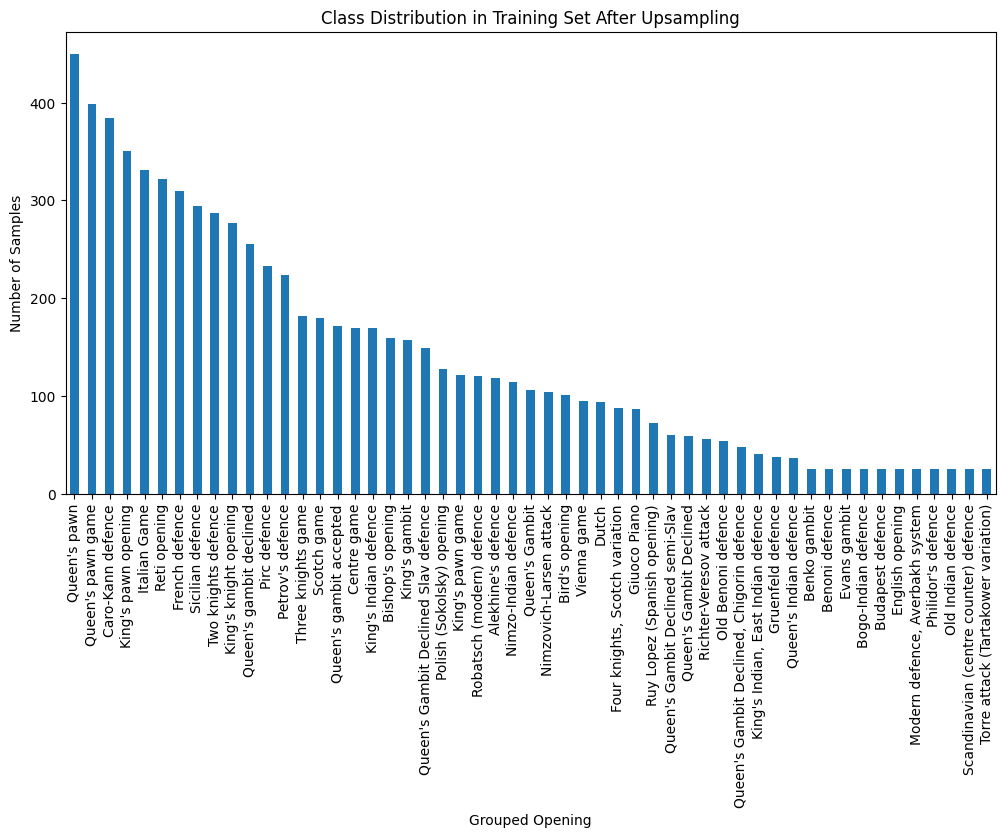

In [10]:
%run DataLoading.py

In [11]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K, Model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [12]:
with open('chess_X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('chess_X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('chess_y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('chess_y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [13]:
unique_classes_train = np.unique(y_train)
unique_classes_test = np.unique(y_test)
y_combined_unique = np.concatenate((unique_classes_train, unique_classes_test))

num_classes = len(np.unique(y_combined_unique))
seq_len = 28

print(X_train.shape)
print(y_train.shape)

input_shape = (seq_len, 8, 8, X_train.shape[4])


(7470, 28, 8, 8, 12)
(7470,)


# CNN -> LSTM Model

Evaluating Combined CNN-LSTM Model...


/home/nmazzy/AppliedMachineLearning/ChessOpenningMovePredictor/.venv/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.1141 - loss: 3.4287
Epoch 2/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3109 - loss: 2.2497
Epoch 3/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4445 - loss: 1.8465
Epoch 4/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5452 - loss: 1.4403
Epoch 5/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6980 - loss: 1.0272
Epoch 6/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7481 - loss: 0.8366
Epoch 7/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8183 - loss: 0.6162
Epoch 8/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8461 - loss: 0.5164
Epoch 9/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8690 - loss: 0.4382
Epoch 10/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8921 - loss: 0.3608
Epoch 11/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9079 - loss: 0.3189
Epoch 12/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 

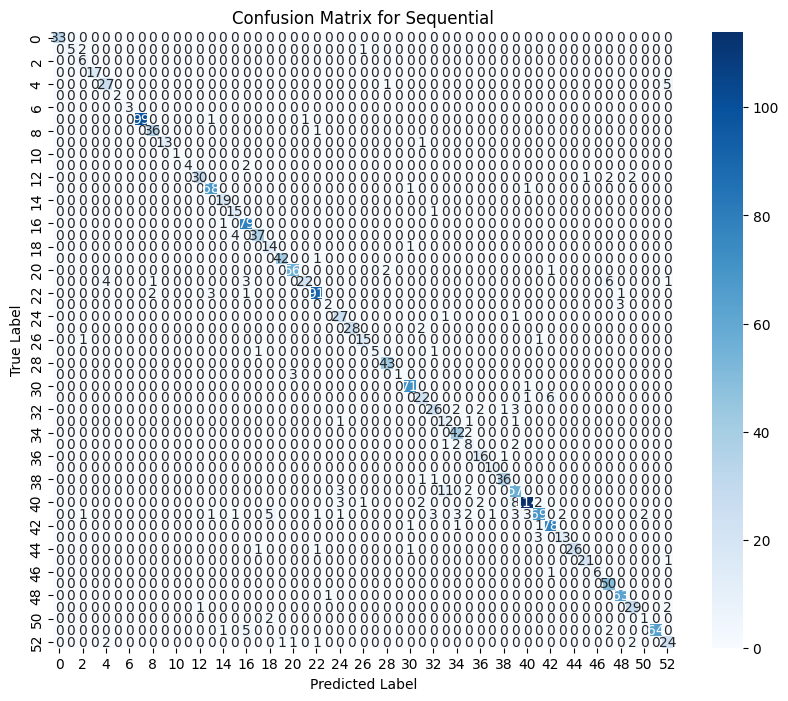

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv3D, Conv2D, Flatten, MaxPooling3D, MaxPooling2D, TimeDistributed, Reshape, Input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Encode labels if they are not already encoded
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# Reshape data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], seq_len, -1)  # Flattening spatial dimensions and channels
X_test_lstm = X_test.reshape(X_test.shape[0], seq_len, -1)

# Combined CNN-LSTM Model
def create_combined_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # CNN layers
    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    # Flatten CNN output
    model.add(TimeDistributed(Flatten()))
    
    # LSTM layers
    model.add(LSTM(100))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Evaluation function for Keras models
def evaluate_keras_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=15):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

# Define input shape
num_classes = y_train_encoded.shape[1]

# Evaluate the combined CNN-LSTM model
print("Evaluating Combined CNN-LSTM Model...")
cnn_lstm_model = create_combined_cnn_lstm_model((seq_len, 8, 8, 12), num_classes)
evaluate_keras_model(cnn_lstm_model, X_train, y_train_encoded, X_test, y_test_encoded)


# CNN -> LSTM w/ Attention Model
https://www.kaggle.com/code/rahulvks/lstm-attention-keras#Building-a-model

In [16]:
from keras.layers import Layer
from keras import initializers, regularizers, constraints

class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

Evaluating Combined CNN-LSTM Model...


/home/nmazzy/AppliedMachineLearning/ChessOpenningMovePredictor/.venv/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1096 - loss: 3.3963
Epoch 2/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2815 - loss: 2.3479
Epoch 3/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4707 - loss: 1.7371
Epoch 4/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6042 - loss: 1.3159
Epoch 5/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7357 - loss: 0.8958
Epoch 6/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7936 - loss: 0.6972
Epoch 7/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8255 - loss: 0.5987
Epoch 8/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8551 - loss: 0.5007
Epoch 9/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8757 - loss: 0.4128
Epoch 10/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9017 - loss: 0.3398
Epoch 11/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9033 - loss: 0.3206
Epoch 12/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 

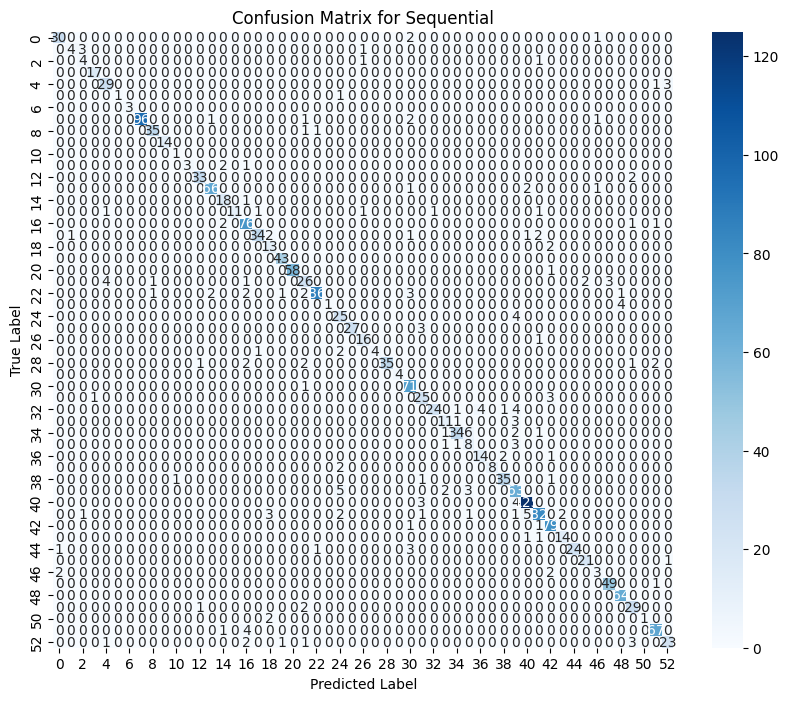

In [19]:
from keras.layers import *
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Encode labels if they are not already encoded
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# Reshape data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], seq_len, -1)  # Flattening spatial dimensions and channels
X_test_lstm = X_test.reshape(X_test.shape[0], seq_len, -1)

def create_combined_cnn_lstm_with_attention(input_shape, num_classes, maxlen):
    # CNN Layers
    model_input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Flatten and reshape
    x = Flatten()(x)
    x = Reshape((maxlen, -1))(x)  # Adjust based on your input dimensions

    # LSTM with Bidirectional wrapper
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)

    # Attention Layer
    x = Attention(step_dim=maxlen)(x)

    # Dense layers
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output Layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = Model(inputs=model_input, outputs=output)
    model.compile(optimizer=nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Evaluation function for Keras models
def evaluate_keras_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=15):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

# Define input shape
num_classes = y_train_encoded.shape[1]

# Evaluate the combined CNN-LSTM model
print("Evaluating Combined CNN-LSTM Model...")
cnn_lstm_attention_model = create_combined_cnn_lstm_model((seq_len, 8, 8, 12), num_classes)
evaluate_keras_model(cnn_lstm_attention_model, X_train, y_train_encoded, X_test, y_test_encoded)
